<a href="https://colab.research.google.com/github/alecbidaran/Pytorch_excersies/blob/main/PTAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ptan
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym[atari]
!pip install pyvirtualdisplay
!pip install piglet


     |████████████████████████████████| 776.7 MB 4.7 kB/s 
  Created wheel for ptan: filename=ptan-0.7-py3-none-any.whl size=23504 sha256=0589cbf699ad412c9acffb0e96d64a71ab7d9adc77017934c64c2352249c5b90
  Stored in directory: /root/.cache/pip/wheels/60/72/3d/a3c47193fdb9efd08e3a54398af996b2989c68571813a71256
Successfully built ptan
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.7.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.7.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.7.0 which is incompatible.
Reading package lists... Done
Building d

In [ ]:
!apt-get install xdpyinfo

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package xdpyinfo


In [ ]:
import gym 
import collections
import ptan 
import numpy as np 
import matplotlib.pyplot as plt
import torch 

In [ ]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [ ]:
##Policies 
selector = ptan.actions.EpsilonGreedyActionSelector(epsilon=0.0)
x=np.array([[1,2,3],[1,-1,0]])
selector(x)

array([2, 0])

# Making DQN with PTAN

In [ ]:
class DQNET(torch.nn.Module):
  def __init__(self,actions):
    super(DQNET,self).__init__()
    self.action=actions
  def forward(self,x):
    return torch.eye(x.size()[0],self.action)



In [ ]:
net=DQNET(actions=3).to("cuda")
net(torch.zeros(2,10))

tensor([[1., 0., 0.],
        [0., 1., 0.]])

In [ ]:
selector=ptan.actions.ArgmaxActionSelector()
agent=ptan.agent.DQNAgent(dqn_model=net,action_selector=selector,device='cuda')

In [ ]:
agent(torch.zeros(2, 5))


(array([0, 1]), [None, None])

# Experiancesource

In [ ]:
from typing import List, Optional, Tuple, Any

In [ ]:
class ToyEnv(gym.Env):
  def __init__(self):
    super(ToyEnv,self).__init__()
    self.observation_space=gym.spaces.Discrete(n=5)
    self.action_space=gym.spaces.Discrete(n=3)
    self.step_index=0
  def reset(self):
    self.step_index=0
    return self.step_index
  def step(self,action):
    is_done=self.step_index==10
    if is_done:
      return self.step_index % self.observation_space.n, \
      0.0, is_done, {}
    self.step_index+=1
    return self.step_index % self.observation_space.n, float(action), self.step_index==10, {}

In [ ]:
class DullAgent(ptan.agent.BaseAgent):
    """
    Agent always returns the fixed action
    """
    def __init__(self, action: int):
        self.action = action

    def __call__(self, observations: List[Any],
                 state: Optional[List] = None) \
            -> Tuple[List[int], Optional[List]]:
        return [self.action for _ in observations], state


In [ ]:
env=ToyEnv()
agent=DullAgent(action=1)
exp_source=ptan.experience.ExperienceSource(env,agent,steps_count=2)
for idx,exp in enumerate(exp_source):
  if idx>2:
    break
  print(exp)

(Experience(state=0, action=1, reward=1.0, done=False), Experience(state=1, action=1, reward=1.0, done=False))
(Experience(state=1, action=1, reward=1.0, done=False), Experience(state=2, action=1, reward=1.0, done=False))
(Experience(state=2, action=1, reward=1.0, done=False), Experience(state=3, action=1, reward=1.0, done=False))


In [ ]:
##using first and last for finding first state and last state for DQN
exp_source=ptan.experience.ExperienceSourceFirstLast(env,agent,gamma=1.0,steps_count=2)
for idx,exp in enumerate(exp_source):
  if idx>10:
    break
  print(exp)

ExperienceFirstLast(state=0, action=1, reward=2.0, last_state=2)
ExperienceFirstLast(state=1, action=1, reward=2.0, last_state=3)
ExperienceFirstLast(state=2, action=1, reward=2.0, last_state=4)
ExperienceFirstLast(state=3, action=1, reward=2.0, last_state=0)
ExperienceFirstLast(state=4, action=1, reward=2.0, last_state=1)
ExperienceFirstLast(state=0, action=1, reward=2.0, last_state=2)
ExperienceFirstLast(state=1, action=1, reward=2.0, last_state=3)
ExperienceFirstLast(state=2, action=1, reward=2.0, last_state=4)
ExperienceFirstLast(state=3, action=1, reward=2.0, last_state=None)
ExperienceFirstLast(state=4, action=1, reward=1.0, last_state=None)
ExperienceFirstLast(state=0, action=1, reward=2.0, last_state=2)


In [ ]:
env=ToyEnv()
agent=DullAgent(action=1)
exp_source=ptan.experience.ExperienceSourceFirstLast(env,agent,gamma=1.0,steps_count=2)
buffer=ptan.experience.ExperienceReplayBuffer(exp_source,buffer_size=100)

In [ ]:
len(buffer)

0

In [ ]:
for step in range(6):
  buffer.populate(1)
  if len(buffer)>5:
    break
  batch=buffer.sample(4)
  print("Train time, %d batch samples:" % len(batch))
  for s in batch:
    print(s)

Train time, 1 batch samples:
ExperienceFirstLast(state=0, action=1, reward=2.0, last_state=2)
Train time, 2 batch samples:
ExperienceFirstLast(state=0, action=1, reward=2.0, last_state=2)
ExperienceFirstLast(state=1, action=1, reward=2.0, last_state=3)
Train time, 3 batch samples:
ExperienceFirstLast(state=0, action=1, reward=2.0, last_state=2)
ExperienceFirstLast(state=1, action=1, reward=2.0, last_state=3)
ExperienceFirstLast(state=2, action=1, reward=2.0, last_state=4)
Train time, 4 batch samples:
ExperienceFirstLast(state=0, action=1, reward=2.0, last_state=2)
ExperienceFirstLast(state=1, action=1, reward=2.0, last_state=3)
ExperienceFirstLast(state=2, action=1, reward=2.0, last_state=4)
ExperienceFirstLast(state=3, action=1, reward=2.0, last_state=0)
Train time, 4 batch samples:
ExperienceFirstLast(state=0, action=1, reward=2.0, last_state=2)
ExperienceFirstLast(state=0, action=1, reward=2.0, last_state=2)
ExperienceFirstLast(state=3, action=1, reward=2.0, last_state=0)
Experience

In [ ]:
#Deep Q network
class DQN(torch.nn.Module):
  def __init__(self):
    super(DQN,self).__init__()
    self.fc=torch.nn.Linear(5,3)
  def forward(self,x):
    return self.fc(x)
net=DQN()

In [ ]:
tgt_net=ptan.agent.TargetNet(net)
tgt_net.sync()

In [ ]:
import torch.functional as F 

In [ ]:
#Deep Q network
class Net(torch.nn.Module):
  def __init__(self,obs_size,actions):
    super(Net,self).__init__()
    self.fc=torch.nn.Sequential(
        torch.nn.Linear(obs_size,128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,actions)
    )
  def forward(self,x):
    return self.fc(x.float())
@torch.no_grad()
def unpack_batch(batch, net, gamma):
    states = []
    actions = []
    rewards = []
    done_masks = []
    last_states = []
    for exp in batch:
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        done_masks.append(exp.last_state is None)
        if exp.last_state is None:
            last_states.append(exp.state)
        else:
            last_states.append(exp.last_state)

    states_v = torch.tensor(states).cuda()
    actions_v = torch.tensor(actions).cuda()
    rewards_v = torch.tensor(rewards).cuda()
    last_states_v = torch.tensor(last_states).cuda()
    last_state_q_v = net(last_states_v).cuda()
    best_last_q_v = torch.max(last_state_q_v, dim=1)[0]
    best_last_q_v[done_masks] = 0.0
    return states_v, actions_v, best_last_q_v * gamma + rewards_v



In [ ]:
BATCH_SIZE = 16
TGT_NET_SYNC = 10
GAMMA = 0.9
REPLAY_SIZE = 1000
LR = 1e-3
EPS_DECAY=0.99
env=gym.make("CartPole-v0")
observation_size=env.observation_space.shape[0]
action_size=env.action_space.n
net=Net(observation_size,action_size).cuda()


In [ ]:
tgt_net=ptan.agent.TargetNet(net)
selector=ptan.actions.ArgmaxActionSelector()
selector=ptan.actions.EpsilonGreedyActionSelector(epsilon=1,selector=selector)
agent=ptan.agent.DQNAgent(net,action_selector=selector,device='cuda')
exp_source=ptan.experience.ExperienceSourceFirstLast(env,agent,gamma=GAMMA)
buffer=ptan.experience.ExperienceReplayBuffer(exp_source,buffer_size=REPLAY_SIZE)
optimizer=torch.optim.Adam(net.parameters(),lr=LR)
loss=torch.nn.MSELoss()

In [ ]:
step = 0
solved = False
Rewards=[]
for episode in range(100000):
  step += 1
  buffer.populate(1)
  for reward, steps in exp_source.pop_rewards_steps():
    print("%d: episode %d done, reward=%.3f, epsilon=%.2f" % (
    step, episode, reward, selector.epsilon))
    Rewards.append(reward)
    solved = reward > 150
    if solved:
      print("Congrats!")
      break

    if len(buffer) < 2*BATCH_SIZE:
      continue
    batch=buffer.sample(BATCH_SIZE)
    state_v, action_v,tgt_q_v=unpack_batch(batch,tgt_net.target_model,GAMMA)
    optimizer.zero_grad()
    q_v=net(state_v)
    q_v=q_v.gather(1,action_v.unsqueeze(-1)).squeeze(-1)
    loss_v=loss(q_v,tgt_q_v)
    loss_v.backward()
    optimizer.step()
    selector.epsilon*=EPS_DECAY
    if steps % TGT_NET_SYNC==0:
      tgt_net.sync()

11: episode 10 done, reward=12.000, epsilon=0.00
20: episode 19 done, reward=9.000, epsilon=0.00
29: episode 28 done, reward=9.000, epsilon=0.00
39: episode 38 done, reward=10.000, epsilon=0.00
50: episode 49 done, reward=11.000, epsilon=0.00
60: episode 59 done, reward=10.000, epsilon=0.00
69: episode 68 done, reward=9.000, epsilon=0.00
78: episode 77 done, reward=9.000, epsilon=0.00
90: episode 89 done, reward=12.000, epsilon=0.00
100: episode 99 done, reward=10.000, epsilon=0.00
111: episode 110 done, reward=11.000, epsilon=0.00
122: episode 121 done, reward=11.000, epsilon=0.00
134: episode 133 done, reward=12.000, epsilon=0.00
142: episode 141 done, reward=8.000, epsilon=0.00
152: episode 151 done, reward=10.000, epsilon=0.00
161: episode 160 done, reward=9.000, epsilon=0.00
170: episode 169 done, reward=9.000, epsilon=0.00
179: episode 178 done, reward=9.000, epsilon=0.00
188: episode 187 done, reward=9.000, epsilon=0.00
197: episode 196 done, reward=9.000, epsilon=0.00
208: epis

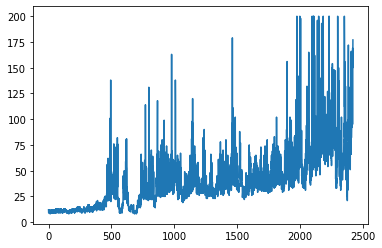

In [ ]:
plt.plot(Rewards)

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [ ]:
env.seed(42)
env.reset()
frame=[]
for step in range(200):
  buffer.populate(1)
  batch=buffer.sample(1)
  state_v, action_v,tgt_q_v=unpack_batch(batch,tgt_net.target_model,GAMMA)
  for action in action_v.cpu().numpy():
    state, reward, done, info = env.step(action)
    if done:
      break
    img = env.render(mode="rgb_array")
    frame.append(img)

plot_animation(frame,repeat=True)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
